In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [31]:
data = pd.read_csv('./data.csv')
data

,Unnamed: 0,text,tags
0,0,While bismuth compounds Pepto Bismol decreased...,"O,B-med,I-med,B-med,I-med,O,O,O,O,O,O,O,O,O,O,..."
1,1,Diarrhea also spelled diarrhoea is the condi...,"B-diag,O,O,B-diag,O,O,O,I-diag,O,O,O,O,O,O,O,B..."
2,2,Antiretroviral therapy ART is recommended for ...,"B-med,I-med,B-med,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
3,3,The following drugs are considered as DMARDs ...,"O,O,O,O,O,O,B-med,B-med,B-med,B-med,B-med,B-me..."
4,4,The goals of treatment are to reduce pain dec...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
5,5,Bats are the most common source of rabies in h...,"O,O,O,O,O,O,O,B-diag,O,O,O,O,O,O,O,O,O,O,O,O,O..."
6,6,In following the outbreak of severe acut...,"O,O,O,O,O,B-diag,I-diag,I-diag,I-diag,B-diag,O..."
7,7,Bacterial vaginosis is caused by bacteria that...,"O,O,O,O,O,O,O,O,I-diag,B-diag,O,O,O,O,O,O,O,O,..."
8,8,One of the bacterial diseases with the highest...,"O,O,O,O,O,O,O,O,O,O,O,B-diag,O,O,O,O,O,O,O,O,O..."
9,9,Although the vast majority of bacteria are har...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."


In [32]:
tags = set()
for tag in data.tags:
    for t in tag.split(','):
        tags.add(t)

label2id = {k: v for v, k in enumerate(tags)}
id2label = {v: k for v, k in enumerate(tags)}
label2id

{'I-med': 0, 'B-diag': 1, 'B-med': 2, 'I-diag': 3, 'O': 4}

In [33]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 100
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [34]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [35]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.text[index]  
        word_labels = self.data.tags[index]  
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)
        
        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]
        
        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [36]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (26, 3)
TRAIN Dataset: (21, 3)
TEST Dataset: (5, 3)


In [37]:
training_set[0]

{'ids': tensor([  101,  1996,  2048,  4280,  1997,  3424, 24093,  2140,  5850,  2109,
          2114, 24442,  2024, 11265, 27618,  5498,  8883,  2063, 25456,  9808,
         20042, 10631, 21663, 23564, 28987, 21663, 17595,  3981,  4328, 21663,
          1998,  2566, 10631, 21663,  1998,  1049,  5250, 25456, 29502,  7231,
         16942,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [38]:
training_set[0]["ids"]

tensor([  101,  1996,  2048,  4280,  1997,  3424, 24093,  2140,  5850,  2109,
         2114, 24442,  2024, 11265, 27618,  5498,  8883,  2063, 25456,  9808,
        20042, 10631, 21663, 23564, 28987, 21663, 17595,  3981,  4328, 21663,
         1998,  2566, 10631, 21663,  1998,  1049,  5250, 25456, 29502,  7231,
        16942,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [39]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:200]), training_set[0]["targets"][:200]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))

[CLS]       O
the         O
two         O
classes     O
of          O
anti        O
##vira      O
##l         O
drugs       O
used        O
against     O
influenza   B-diag
are         O
ne          O
##uram      O
##ini       O
##das       O
##e         O
inhibitors  O
os          B-med
##elt       B-med
##ami       B-med
##vir       B-med
za          B-med
##nami      B-med
##vir       B-med
lan         B-med
##ina       B-med
##mi        B-med
##vir       B-med
and         O
per         B-med
##ami       B-med
##vir       B-med
and         O
m           O
protein     O
inhibitors  O
adamant     O
##ane       O
derivatives  O
[SEP]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O


In [40]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [41]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', 
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
device = 'mps'
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [42]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(1.6977, device='mps:0', grad_fn=<NllLossBackward0>)

In [43]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 5])

In [44]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [45]:
# Defining the training function on the 80% of the dataset for tuning the bert model
history = {"loss":[], "acc":[]}
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_preds.extend(predictions)
        tr_labels.extend(targets)
        
        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    history['loss'].append(epoch_loss)
    history['acc'].append(tr_accuracy)
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [46]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 1.7080225944519043
Training loss epoch: 1.3741031885147095
Training accuracy epoch: 0.48543414587095995
Training epoch: 2
Training loss per 100 training steps: 1.0299434661865234
Training loss epoch: 0.8648118178049723
Training accuracy epoch: 0.8111399567808585
Training epoch: 3
Training loss per 100 training steps: 0.6114397048950195
Training loss epoch: 0.6318400849898657
Training accuracy epoch: 0.8367048003570212
Training epoch: 4
Training loss per 100 training steps: 0.9243603944778442
Training loss epoch: 0.5293005506197611
Training accuracy epoch: 0.8414711521024548
Training epoch: 5
Training loss per 100 training steps: 0.5655060410499573
Training loss epoch: 0.512587328751882
Training accuracy epoch: 0.8338489549368169
Training epoch: 6
Training loss per 100 training steps: 0.5061646699905396
Training loss epoch: 0.4493737469116847
Training accuracy epoch: 0.838715072219791
Training epoch: 7
Training loss per 100 trainin

In [47]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(targets)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy
    
    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [48]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.29725661873817444
Validation Loss: 0.3455126980940501
Validation Accuracy: 0.9293154761904763


In [49]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

              precision    recall  f1-score   support

        diag       0.50      0.57      0.53        23
         med       0.94      0.69      0.79        45

   micro avg       0.75      0.65      0.69        68
   macro avg       0.72      0.63      0.66        68
weighted avg       0.79      0.65      0.71        68



In [50]:
sentence = "Add in the medication section, Panadol for 3 times a day, Augmentine for 1 time a day and Xanax for 2 times a day and Add in the \
  diagnosis section the patient caught cold, fever and the flu."
inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)

add in the medication section , panadol for 3 times a day , augmentine for 1 time a day and xanax for 2 times a day and add in the diagnosis section the patient caught cold , fever and the flu .
['O', 'O', 'O', 'O', 'O', 'O', 'B-med', 'B-med', 'B-med', 'O', 'O', 'O', 'O', 'O', 'O', 'B-med', 'B-med', 'B-med', 'O', 'O', 'O', 'O', 'O', 'O', 'B-med', 'B-med', 'B-med', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-diag', 'O', 'B-diag', 'O', 'O', 'B-diag', 'O']


In [51]:
from transformers import pipeline

pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe(sentence)

[{'entity_group': 'med',
  'score': 0.993288,
  'word': 'pan',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.99448085,
  'word': '##ado',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.993292,
  'word': '##l',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.9876632,
  'word': 'aug',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.9885252,
  'word': '##ment',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.993755,
  'word': '##ine',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.94913113,
  'word': 'x',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.90969384,
  'word': '##ana',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.8871404,
  'word': '##x',
  'start': None,
  'end': None},
 {'entity_group': 'diag',
  'score': 0.8485467,
  'word': 'cold',
  'start': None,
  'end': None},
 {'entity_group': 'di

In [52]:
model.save_pretrained('./model')

In [53]:
model = BertForTokenClassification.from_pretrained('./model')

In [54]:
pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe(sentence)

[{'entity_group': 'med',
  'score': 0.993288,
  'word': 'pan',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.99448085,
  'word': '##ado',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.993292,
  'word': '##l',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.9876632,
  'word': 'aug',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.9885252,
  'word': '##ment',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.993755,
  'word': '##ine',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.94913113,
  'word': 'x',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.90969384,
  'word': '##ana',
  'start': None,
  'end': None},
 {'entity_group': 'med',
  'score': 0.8871404,
  'word': '##x',
  'start': None,
  'end': None},
 {'entity_group': 'diag',
  'score': 0.8485467,
  'word': 'cold',
  'start': None,
  'end': None},
 {'entity_group': 'di

In [55]:
history

{'loss': [1.3741031885147095,
  0.8648118178049723,
  0.6318400849898657,
  0.5293005506197611,
  0.512587328751882,
  0.4493737469116847,
  0.4407398005326589,
  0.4058378090461095,
  0.4075089246034622,
  0.34528516232967377,
  0.3493104924758275,
  0.3320106665293376,
  0.2698025008042653,
  0.26451612263917923,
  0.26568352182706195,
  0.24845203757286072,
  0.21172836174567541,
  0.24192509055137634,
  0.187704307337602,
  0.20952611913283667,
  0.18122842411200205,
  0.15387250607212385,
  0.1653576319416364,
  0.13677252332369486,
  0.15389395381013551,
  0.11564348607013623,
  0.1291948805252711,
  0.1065088367710511,
  0.1219206154346466,
  0.1097831850250562,
  0.1104371336599191,
  0.07809016310299437,
  0.08767423530419667,
  0.09010637986163299,
  0.06700932048261166,
  0.08573664414385955,
  0.06727658212184906,
  0.07113833725452423,
  0.05708853000154098,
  0.05136923911049962,
  0.060455511013666786,
  0.050042103976011276,
  0.06075748987495899,
  0.05308220194031795,

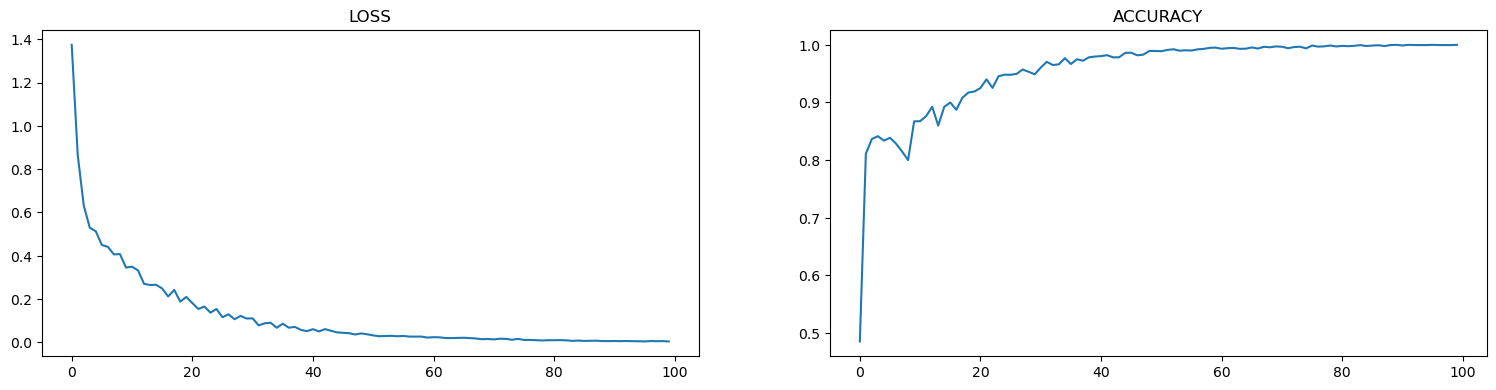

In [85]:
import matplotlib.pyplot as plt

x = np.arange(EPOCHS)


plt.figure(figsize=(100,50))


plt.subplot(10,10,1)
plt.plot(x,history['loss'])
plt.title('LOSS')


plt.subplot(10,10,2)
plt.plot(x,history['acc'])
plt.title('ACCURACY')

plt.show()